# TimeSeries Drifter Data - Quick Plot - Multideployment

From an erddap Dataset, specify the Drifter IDs to get a quick plot of the data

In [1]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import EcoFOCIpy.math.cleaning as cleaning #<- instrument specific


In [2]:
server_url = 'http://ecofoci-field.pmel.noaa.gov:8082/erddap'
dataset_name = {'2024':'2024_Argos_Drifters_NRT',
                '2025':'2025_Argos_Drifters_NRT',
               }

In [3]:
pdf = {}             

In [129]:
e = ERDDAP(server=server_url,
          protocol='tabledap',
          response='csv')

for ds,dn in enumerate(dataset_name):
        
    e.dataset_id=dataset_name[dn]
    
    df = e.to_pandas(
                index_col='time (UTC)',
                parse_dates=True,
                skiprows=(1,)  # units information can be dropped.
            )
    df.columns = [x.split()[0] for x in df.columns]
    df.index.rename('time',inplace=True)
    df.index = df.index.tz_localize(None)
    pdf.update({dn:df})

In [130]:
for datasets in pdf:
    pdf[datasets] = pdf[datasets][pdf[datasets]['trajectory_id'] == 237948].to_xarray() 
    pdf[datasets] = pdf[datasets].drop_duplicates(dim='time').sortby('time')

In [166]:
N = 3 #which is N*2+1 for hour window
clean = cleaning.rolling_outlier_std(pdf['2024'],'sst',timebase=N*2+1,stddev=5,interp_fill_timebase='1h')
clean2 = cleaning.rolling_outlier_std(clean,'sst',timebase=N*2+1,stddev=3,interp_fill_timebase='1h')

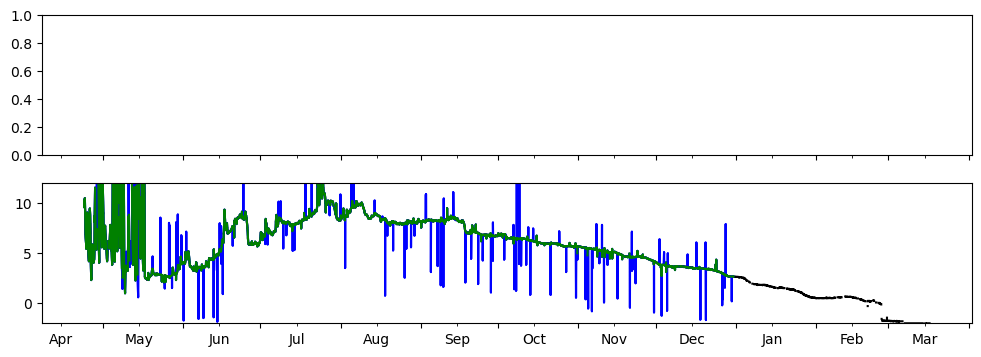

In [169]:
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter

fig, ax = plt.subplots(2,figsize=(12, 4),sharex=True)
for datasets in pdf:
    tdf = pdf[datasets].where(pdf[datasets].location_quality != 1)
    # ax[0].plot(tdf.time,tdf.strain,'r')
    # ax[1].plot(tdf.time,tdf.sst,'r')
    ax[1].plot(tdf.sortby('time').rolling(dim={'time':5}, center=True).median().time, #rolling('1D').mean()
               tdf.sortby('time').rolling(dim={'time':5}, center=True).median().sst,'k')
    ax[1].plot(clean.time,clean.sst,'b')
    ax[1].plot(clean2.time,clean2.sst,'g')

ax[1].set_ylim([-2,12])
# xfmt = mdates.DateFormatter('%d-%b')
ax[1].xaxis.set_major_locator(MonthLocator(bymonth=range(1,13,1)))
ax[1].xaxis.set_minor_locator(MonthLocator(bymonth=range(1,13,1),bymonthday=15))
ax[1].xaxis.set_minor_formatter(DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(DateFormatter(''))
ax[1].xaxis.set_tick_params(which='major', pad=3)
ax[1].xaxis.set_tick_params(which='minor', pad=5)

In [173]:
import pygmt
import matplotlib as mpl
import cmocean

cmap = plt.cm.magma  # define the colormap
# extract all colors from the .jet map
num=48
cmaplist = [mpl.colors.to_hex(cmap(i)) for i in range(0,cmap.N,int(cmap.N/num))]

In [174]:
fig = pygmt.Figure()

fig.coast(region=[-180, -150, 55, 62.5], projection='B-165/65/40/60/6i', land='lightgray', water='gray',
          frame=True)

In [175]:
count=0
for traj in pdf.keys():
    fig.plot(x=pdf[traj].longitude, y=pdf[traj].latitude, cmap=cmaplist[count], style='p0.0125')
    print(cmaplist[count]+"\t : \t"+str(traj))
    count+=1

#000004	 : 	2024
#02020b	 : 	2025


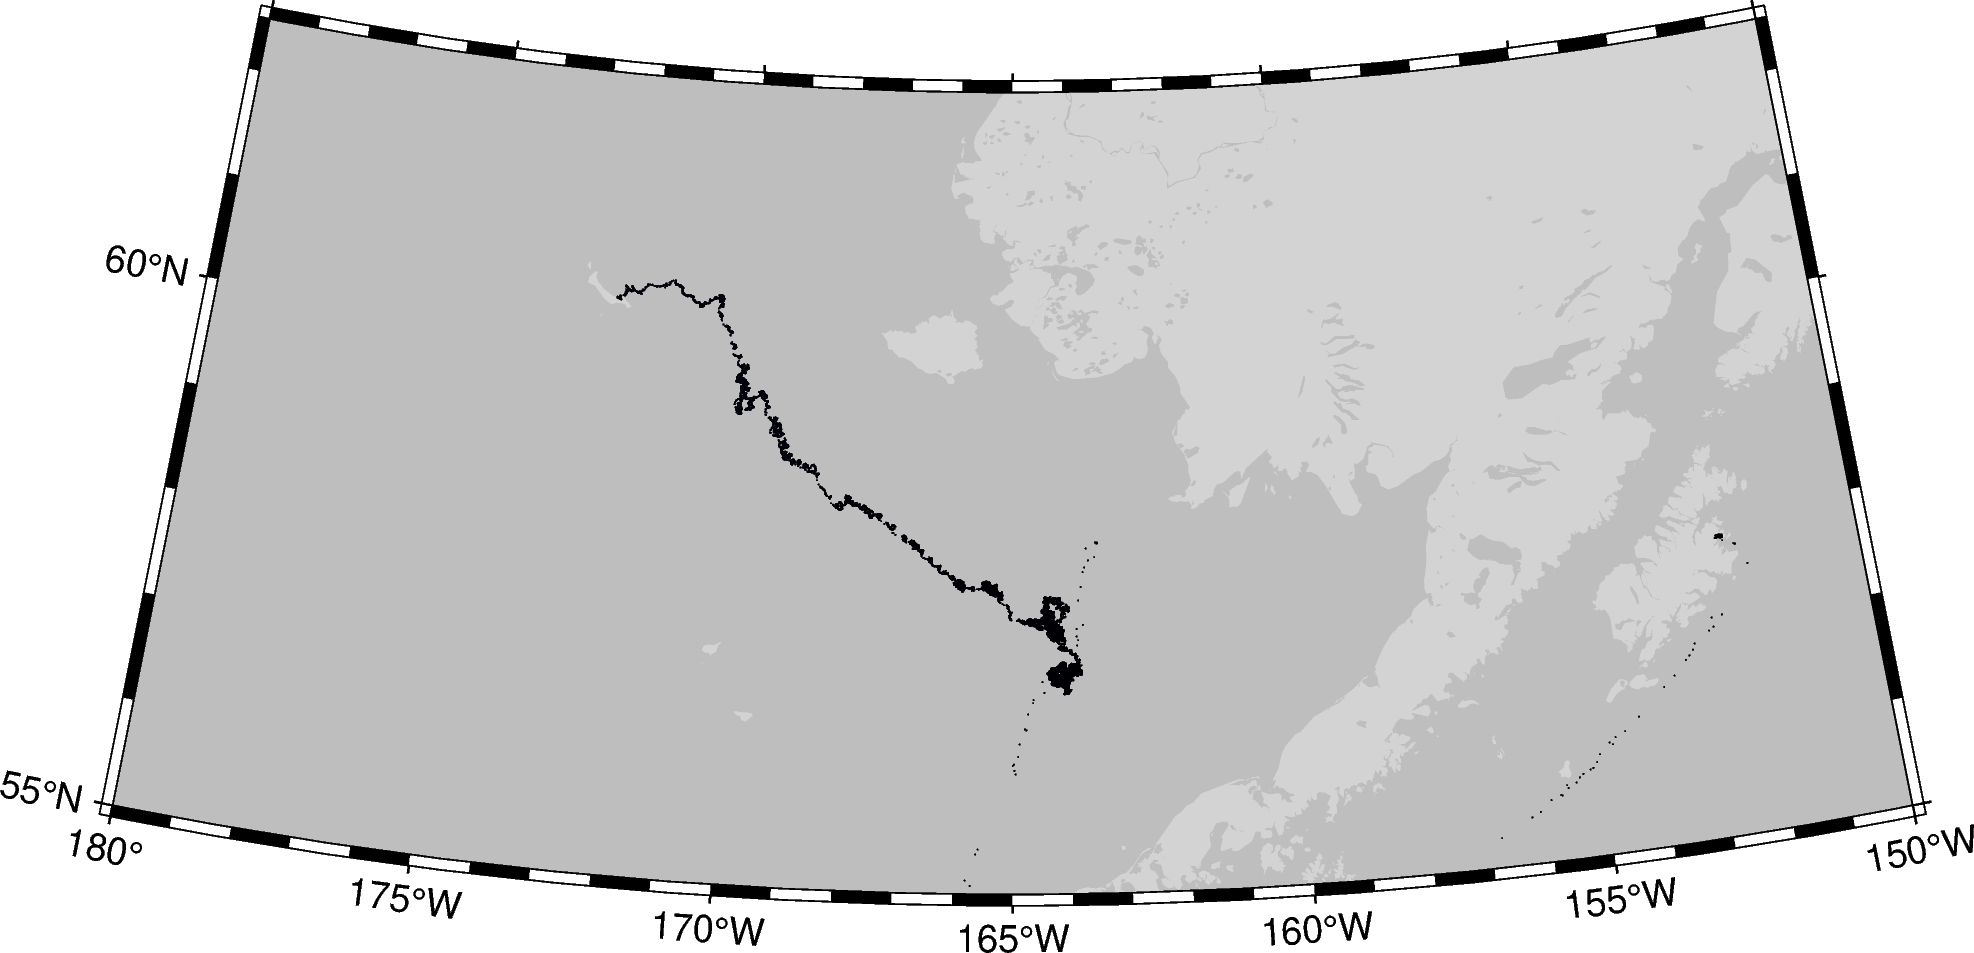

In [176]:
fig.show()